In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from simulation import FridgeDRSim

In [2]:
sim = FridgeDRSim()

2024-01-01
2024-03-10


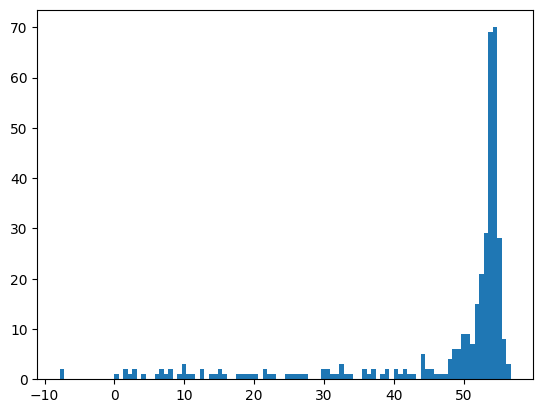

In [3]:
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')

peak_shaving = []
for dt in dates:
    date = dt.strftime('%Y-%m-%d')
    try:
        results = sim.run(date)
        peak_shaving.append(results['stats']['mw_reduction'])
    except:
        print(date)

peak_shaving = np.array(peak_shaving)
plt.hist(peak_shaving, bins=100);